In [185]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
from typing import Tuple, List
from pydantic import BaseModel, Field
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# load results

In [186]:
# pydantic model

class PreprocessingSteps(BaseModel):
    transformers: Tuple[
        Tuple[PCA, StandardScaler, np.ndarray, np.ndarray],
        Tuple[float, float]
    ] = Field(
        ..., 
        description="Preprocessing steps including PCA, StandardScaler, and arrays"
    )

    class Config:
        arbitrary_types_allowed = True
        json_encoders = {
            np.ndarray: lambda v: v.tolist(),
            PCA: lambda v: str(v),
            StandardScaler: lambda v: str(v)
        }


In [187]:
def load_data(dataset: str) -> dict:
    """
    Load data from pickle files for a specific dataset.
    
    Args:
        dataset (str): Name of the dataset or specific subdirectory
    
    Returns:
        dict: A dictionary with full file paths as keys and loaded data as values
    """
    
    base_dir = "../results/datasets/real_world_data"
    if dataset in ["circles", "spheres", "alternate_stripes"]:
        base_dir = "../results/datasets/synthetic_data"
    
    full_path = os.path.join(base_dir, dataset)
    
    data_dict = {}
    
    # Walk through the directory tree starting from the specified dataset path
    for root, dirs, files in os.walk(full_path):
        for file in files:
            # Check if the file is a pickle file
            if file.endswith('.pkl') or file.endswith('.p'):
                full_file_path = os.path.join(root, file)
                
                try:
                    # Load the pickle file
                    with open(full_file_path, "rb") as f:
                        data = pickle.load(f)
                    
                    # Store in the dictionary with full path as key
                    data_dict[full_file_path] = data
                
                except (IOError, pickle.UnpicklingError) as e:
                    print(f"Error loading {full_file_path}: {e}")
    
    return data_dict

# functions to collate the data

In [188]:
# get the explained variance objectives for train and validation

def extract_explained_variance(data: list[list[PreprocessingSteps]]) -> np.array:

    explained_variance = []
    
    for j in range(len(data)):
        
        data_run = [data[j][i][-1] for i in range(len(data[j]))]
        explained_variance.append(data_run)
    print(len(explained_variance))
    return np.array(explained_variance)

# visualise

In [257]:
def plot_percentiles(data):

    # Compute percentiles along the first axis (runs)
    p20 = np.percentile(data, 20, axis=0)
    p50 = np.percentile(data, 50, axis=0)
    p80 = np.percentile(data, 80, axis=0)
    
    # Create x-axis (time steps)
    x = np.arange(data.shape[1])
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    # plt.ylim(0.5, 1.0)
    
    # Plot for each dimension of the last axis
    colors = ['blue', 'red']
    labels = ['Dimension 1', 'Dimension 2']
    
    for dim in range(2):
        plt.fill_between(x, p20[:, dim], p80[:, dim], alpha=0.2, color=colors[dim])
        plt.plot(x, p50[:, dim], color=colors[dim], label=f'{labels[dim]} Median')
        
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.title('Percentile Visualization')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [249]:
data_dictionary = load_data("spheres")

In [250]:
data_dictionary.keys()

dict_keys(['../results/datasets/synthetic_data/spheres/activation=relu/partial_contrib=True/0.p', '../results/datasets/synthetic_data/spheres/activation=relu/partial_contrib=True/16.p', '../results/datasets/synthetic_data/spheres/activation=relu/partial_contrib=True/18.p', '../results/datasets/synthetic_data/spheres/activation=relu/partial_contrib=True/9.p', '../results/datasets/synthetic_data/spheres/activation=relu/partial_contrib=True/22.p', '../results/datasets/synthetic_data/spheres/activation=relu/partial_contrib=True/11.p', '../results/datasets/synthetic_data/spheres/activation=relu/partial_contrib=True/17.p', '../results/datasets/synthetic_data/spheres/activation=relu/partial_contrib=True/12.p', '../results/datasets/synthetic_data/spheres/activation=relu/partial_contrib=True/28.p', '../results/datasets/synthetic_data/spheres/activation=relu/partial_contrib=True/2.p', '../results/datasets/synthetic_data/spheres/activation=relu/partial_contrib=True/14.p', '../results/datasets/syn

In [251]:
partial_contrib_data = [value for key, value in data_dictionary.items() if 'True' in key]
full_contrib_data = [value for key, value in data_dictionary.items() if 'False' in key]

In [252]:
len(partial_contrib_data)

30

In [253]:
explained_variance_partial = extract_explained_variance(partial_contrib_data)

30


In [254]:
explained_variance_full = extract_explained_variance(full_contrib_data)

0


In [255]:
# wine

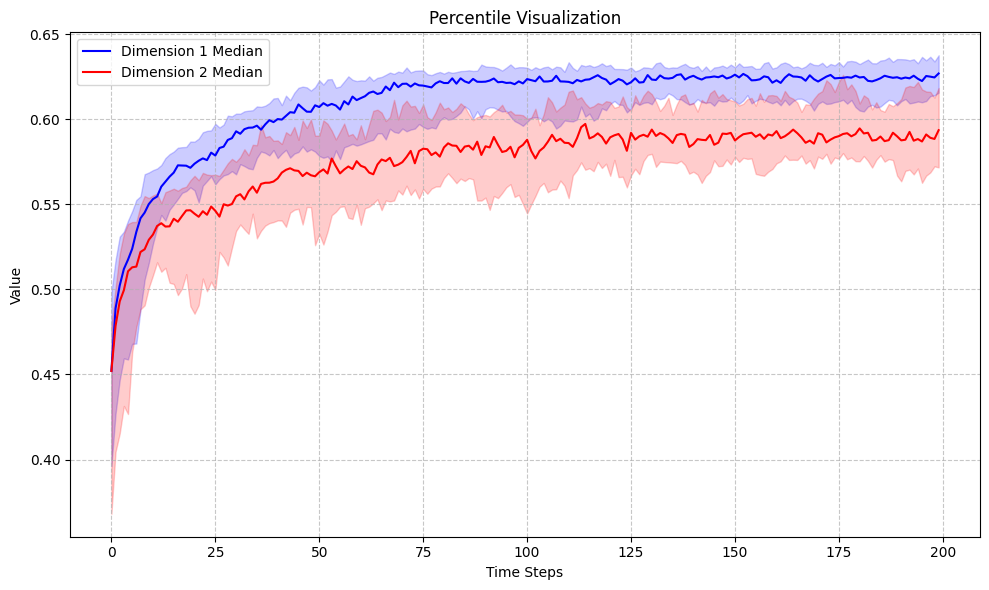

In [258]:
# with batch norm

plot_percentiles(explained_variance_partial)

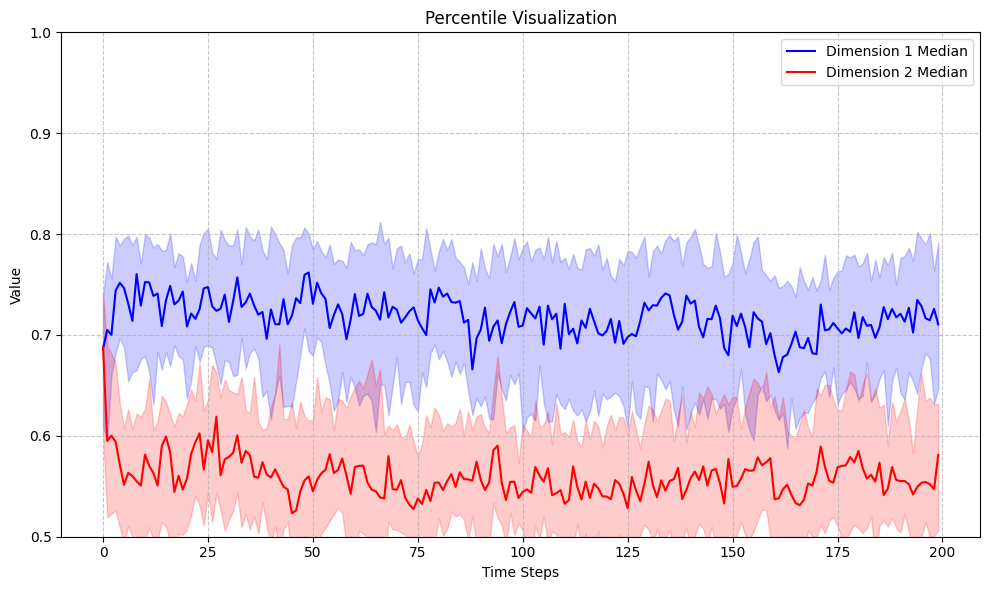

In [248]:
plot_percentiles(explained_variance_full)

In [208]:
# circles

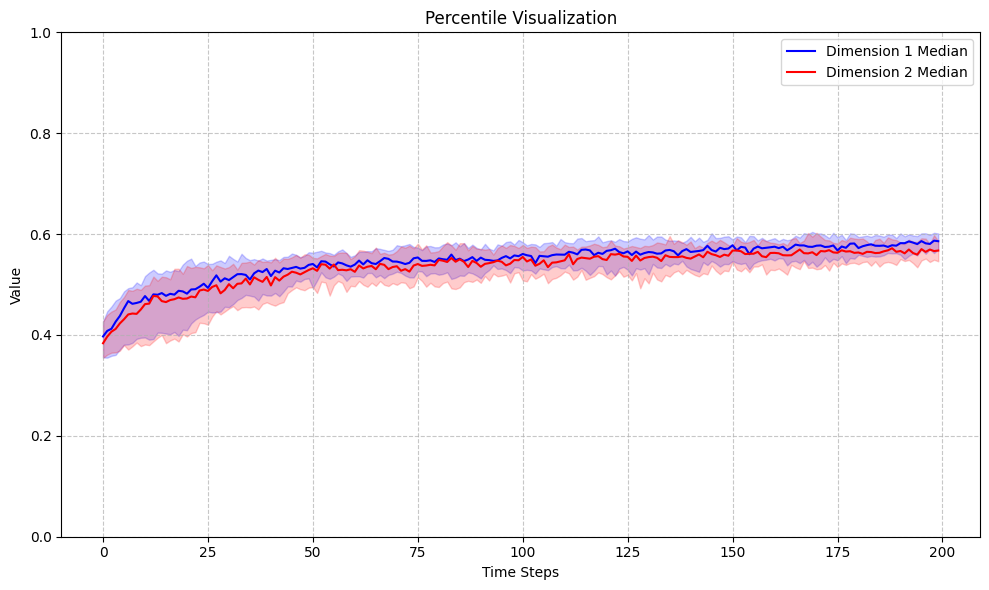

In [58]:
plot_percentiles(explained_variance_partial)

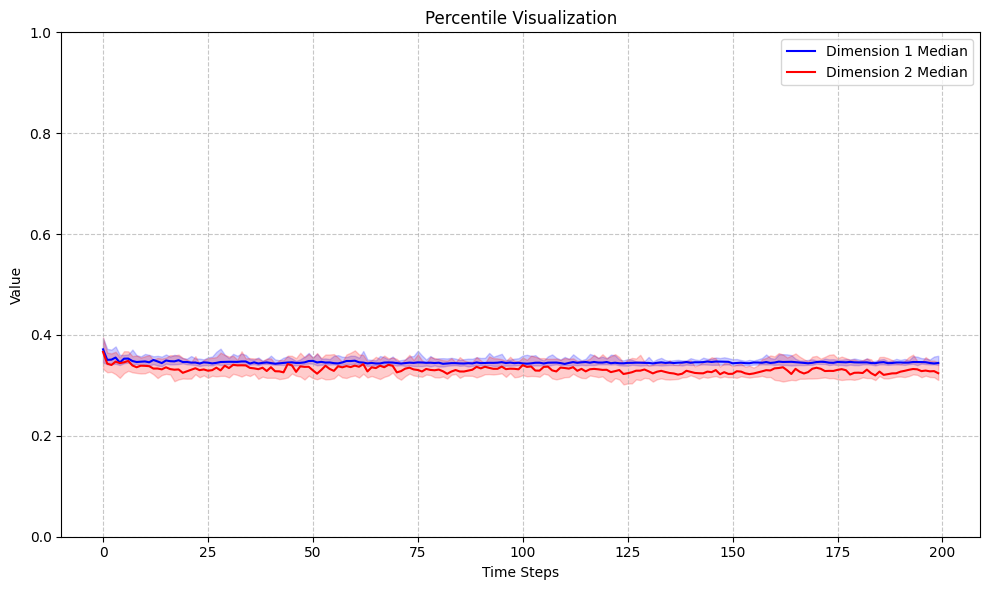

In [59]:
plot_percentiles(explained_variance_full)

In [ ]:
# spheres

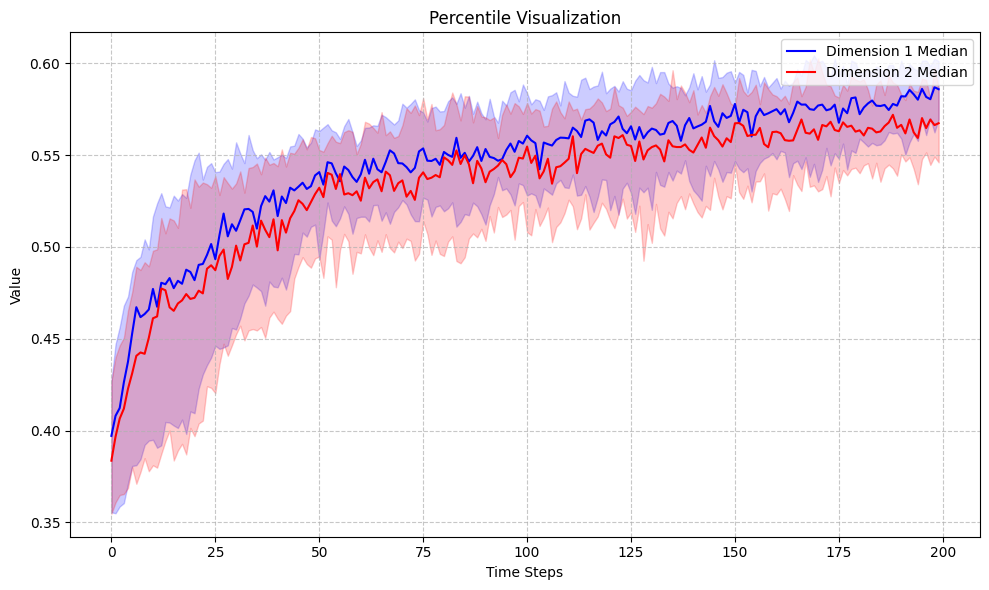

In [55]:
plot_percentiles(explained_variance_partial)

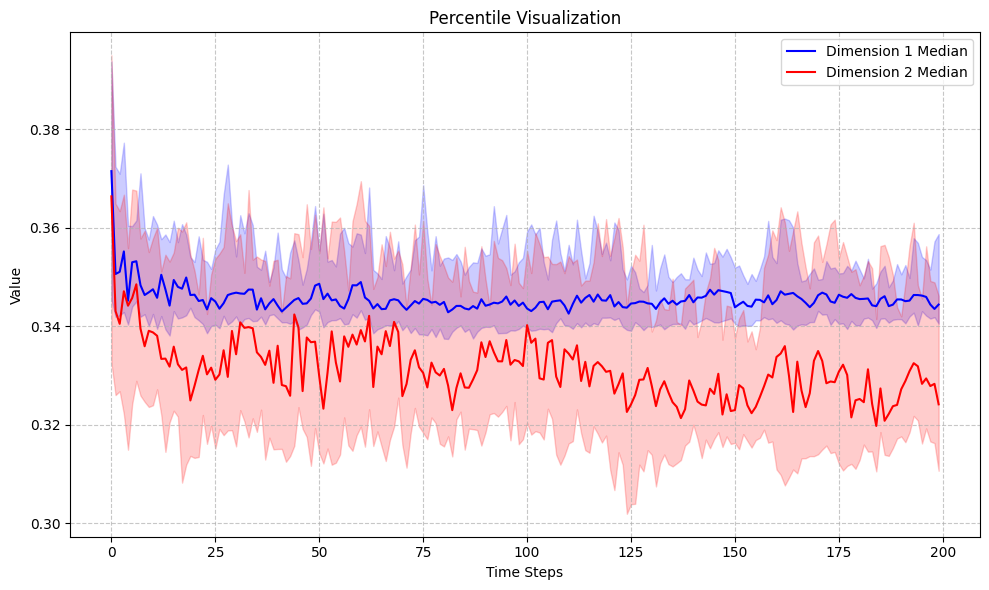

In [56]:
plot_percentiles(explained_variance_full)

In [76]:
import numpy as np

def compute_last_layer_weights(previous_layer_weights):
    """
    Compute the last layer weight matrix that reconstructs the input.
    
    Parameters:
    previous_layer_weights (numpy.ndarray): Weight matrix of the previous layer
    
    Returns:
    numpy.ndarray: Weight matrix that reconstructs the input
    """
    # Compute the pseudoinverse of the previous layer's weights
    # This ensures we can exactly reconstruct the input
    last_layer_weights = np.linalg.pinv(previous_layer_weights)
    
    return last_layer_weights

# Example demonstration
def example_usage():
    # Simulate a network with layers
    previous_layer_weights = np.random.randn(20, 10)  # Previous layer: 3 neurons, maps from 5-dimensional input
    
    # Compute the last layer weights
    last_layer_weights = compute_last_layer_weights(previous_layer_weights)
    
    # Verify reconstruction
    # Generate a random input
    input_vector = np.random.randn(20)
    
    # Simulate forward pass through previous layer
    hidden_layer_output = input_vector @ previous_layer_weights
    
    # Reconstruct input using the computed last layer weights
    reconstructed_input = hidden_layer_output @ last_layer_weights
    
    print("Original Input:       ", input_vector)
    print("Reconstructed Input:  ", reconstructed_input)
    print("Reconstruction Error: ", np.linalg.norm(input_vector - reconstructed_input))

In [77]:
example_usage()

Original Input:        [ 0.62385879  0.25856808 -0.11942491  1.28761996  0.44626324  0.18172981
 -0.10854677  0.80816609 -0.11867303 -0.89220863  1.93631597 -0.49635602
  1.00644446 -0.13524705 -0.64108066  1.21131605  2.23556502  1.51702743
  1.46551234 -1.28196916]
Reconstructed Input:   [-0.95792272  0.3779226   0.45575444  0.2079865   0.09378632  0.62140206
 -0.20249102  0.75383684  0.63984438 -0.79402394  0.8897661  -0.2094883
  0.74316732 -0.41228192 -0.11870817  0.27321145  0.35968414 -0.28673749
  0.63916684 -0.12711018]
Reconstruction Error:  4.024004839724385


In [80]:
import numpy as np

def compute_last_layer_weights(previous_layer_weights):
    """
    Compute the last layer weight matrix that reconstructs the input.
    
    Parameters:
    previous_layer_weights (numpy.ndarray): Weight matrix of the previous layer
    
    Returns:
    numpy.ndarray: Weight matrix that reconstructs the input
    """
    # Compute the pseudoinverse of the previous layer's weights
    # This ensures we can exactly reconstruct the input
    last_layer_weights = np.linalg.pinv(previous_layer_weights)
    
    return last_layer_weights

# Example demonstration
def example_usage():
    # Simulate a network with layers
    previous_layer_weights = np.random.randn(10, 20)  # Previous layer: 3 neurons, maps from 5-dimensional input
    
    # Compute the last layer weights
    last_layer_weights = compute_last_layer_weights(previous_layer_weights)
    
    # Verify reconstruction
    # Generate a random input
    input_vector = np.random.randn(20)
    
    # Simulate forward pass through previous layer
    hidden_layer_output = previous_layer_weights @ input_vector
    
    # Reconstruct input using the computed last layer weights
    reconstructed_input = last_layer_weights @ hidden_layer_output
    
    print("Original Input:       ", input_vector)
    print("Reconstructed Input:  ", reconstructed_input)
    print("Reconstruction Error: ", np.linalg.norm(input_vector - reconstructed_input))

In [81]:
example_usage()

Original Input:        [ 0.94121349  0.11740524  0.23806222  1.34337068 -1.20101885 -0.0784646
  0.61369477  0.18170189 -0.24807906 -0.48791499  0.82361223 -0.8773358
 -0.82022103  0.47342708 -0.10120492 -1.63066781 -0.03862395  1.63580604
 -1.25968754 -0.02511189]
Reconstructed Input:   [ 0.48274615  0.50121635 -0.56309567  0.95104286 -1.32736608 -0.15956181
  0.65501976 -0.01636311 -0.33212639  0.27293632  0.64684621 -0.62208923
 -0.30188079  0.61633791 -0.2945673  -1.61600447  0.14629453  1.59159346
 -0.9042642   0.40879438]
Reconstruction Error:  1.6051685502582873
